In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import multiprocessing as mp
from scipy.spatial.distance import cdist
from itertools import repeat

def choose_centroids(n, k):
    import random as rd
    centroids_idx = rd.sample(range(n), k)
    centroids_idx.sort()
    return centroids_idx


def distance(centroid, datapoint):
    return sqrt(np.square(centroid - datapoint).sum())

def find_cluster(data, centroids):
    distances = cdist(data, centroids, 'euclidean')
    return np.argmin(distances, axis=1)

def Kmeans(df, cidx, n, k):
    iterations = 0
    time = []
    centroids = df.loc[cidx]
    clusters = np.zeros(n, dtype=int)

    while iterations < 100:
        startit = timer()

        iterations += 1
        old_clusters = clusters.copy()
        clusters = find_cluster(df.values,centroids.values)
        endit = timer() - startit
        time.append(endit)

        if np.array_equal(clusters, old_clusters):
            break

        for j in range(k):
            centroids.loc[cidx[j]] = df.loc[clusters == j].mean(axis=0)

    return np.mean(np.asarray(time)), clusters


def mpKmeans(df, cidx, n, k, cpus):
    iterations = 0
    time = []
    centroids = df[cidx]
    clusters = np.zeros(n, dtype=int)

    split_data = np.array_split(df, cpus)

    while iterations < 100:
        startit = timer()

        iterations += 1
        old_clusters = clusters.copy()

        arg = zip(split_data, repeat(centroids))
        #print("tic")
        with mp.Pool(processes=cpus) as pool:
        
            split_clusters = pool.starmap(find_cluster, arg)
 
        #print("tac")
        clusters = np.concatenate(split_clusters)

        endit = timer() - startit
        time.append(endit)

        if np.array_equal(clusters, old_clusters):
            break

        # update Cluster centroids
        for j in range(k):
            centroids[j] = df[clusters == j].mean(axis=0)

    return np.mean(np.asarray(time)), clusters


def run_kmeans():
    df = pd.read_csv('data.csv')

    # Parameters for Kmeans
    k = [2,4,8,16,32,64,128,256,512,1024] 
    n = df.shape[0]  
    att = df.shape[1]

    print("Number of Datapoints =", n)
    print("Number of Attributes=", att)

    # time taken to run different algorithms
    time_kmeans = np.zeros(len(k), dtype=float)
    time_mp = np.zeros(len(k), dtype=float)

    # iteration count in different algortihms
    iter_kmeans = np.zeros(len(k), dtype=float)
    iter_mp = np.zeros(len(k), dtype=float)

    # Differnces in the results
    diff_mp_km = np.zeros(len(k), dtype=int)

    # Initial centroids
    for i in range(len(k)):
        centroids_idx = choose_centroids(n, k[i])
        print("Number of Clusters to be formed:", k[i])
        print("\tTime")

        # running normal kmeans algorithms
        start_k = timer()
        iter_kmeans[i], clusters_kmeans = Kmeans(df, centroids_idx, n, k[i])
        time_kmeans[i] = timer() - start_k
        print('Kmeans:\t%4.4f' % (time_kmeans[i]))

        # running kmeans algorithm with parallel computing using Multiprocessing module
        start_m = timer()
        cpus = mp.cpu_count()
        iter_mp[i], clusters_mp = mpKmeans(df.values, centroids_idx, n, k[i], cpus)
        time_mp[i] = timer() - start_m
        print('MProcs:\t%4.4f' % (time_mp[i]))

        # Calculating difference between results
        diff_mp_km[i] = sum(clusters_kmeans != clusters_mp)

        if diff_mp_km[i] != 0:
            print("Cluster Differences: Kmeans Vs Multiprocessing :", diff_mp_km[i])

    # Plotting 
    plt.plot(k, time_kmeans, 'r-', k, time_mp, 'g-')
    plt.title("Time Comparisons for Data of Size 4898 x 8")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Time Taken to Run Clustering Algorithm")
    plt.legend(("Sequencial K-Means", "Parallel K-Means"), loc='best')
    plt.show()


Number of Datapoints = 4998
Number of Attributes= 2
Number of Clusters to be formed: 2
	Time
Kmeans:	0.0266
MProcs:	1.4052
Number of Clusters to be formed: 4
	Time
Kmeans:	0.0261
MProcs:	1.4191
Number of Clusters to be formed: 8
	Time
Kmeans:	0.6787
MProcs:	5.2256
Number of Clusters to be formed: 16
	Time
Kmeans:	0.2015
MProcs:	2.7534
Number of Clusters to be formed: 32
	Time
Kmeans:	0.9376
MProcs:	6.6802
Number of Clusters to be formed: 64
	Time
Kmeans:	0.9511
MProcs:	3.5544
Number of Clusters to be formed: 128
	Time
Kmeans:	2.3165
MProcs:	4.2699
Number of Clusters to be formed: 256
	Time
Kmeans:	2.5321
MProcs:	2.7577
Number of Clusters to be formed: 512
	Time
Kmeans:	7.9781
MProcs:	4.5918
Number of Clusters to be formed: 1024
	Time
Kmeans:	10.3530
MProcs:	3.2980


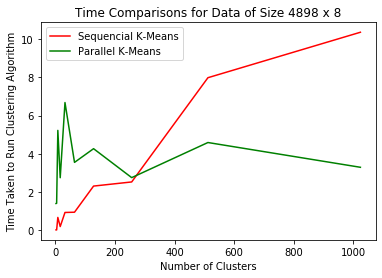

In [2]:
run_kmeans()

Number of Datapoints = 4998
Number of Attributes= 2
Number of Clusters to be formed: 2
	Time
Kmeans:	0.0579
MProcs:	1.6987
Number of Clusters to be formed: 4
	Time
Kmeans:	0.0360
MProcs:	1.9146
Number of Clusters to be formed: 8
	Time
Kmeans:	0.0476
MProcs:	1.4214
Number of Clusters to be formed: 16
	Time
Kmeans:	0.1735
MProcs:	2.6842
Number of Clusters to be formed: 32
	Time
Kmeans:	0.4186
MProcs:	3.1241
Number of Clusters to be formed: 64
	Time
Kmeans:	1.4936
MProcs:	6.0371
Number of Clusters to be formed: 128
	Time
Kmeans:	1.7993
MProcs:	3.5676
Number of Clusters to be formed: 256
	Time
Kmeans:	6.3927
MProcs:	5.8377
Number of Clusters to be formed: 512
	Time
Kmeans:	4.8419
MProcs:	2.7379
Number of Clusters to be formed: 1024
	Time
Kmeans:	11.9840
MProcs:	3.6255
Cluster Differences: Kmeans Vs Multiprocessing : 4


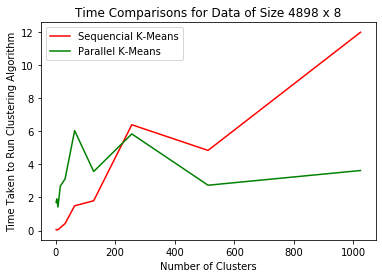

In [2]:
run_kmeans()